In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel


#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn.mass_univariate import permuted_ols

In [2]:
def calculate_pvalues(df):
    from scipy.stats import pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [3]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
df = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), index_col=0, header=0)
df_ladies = df[df['Sex'] == 'F']
df_ladies = df_ladies.drop('Sex', axis=1)
df_dudes = df[df['Sex'] == 'M']
df_dudes = df_dudes.drop('Sex', axis=1)

df_ladies['const'] = 1
df_dudes['const'] = 1

rsgt_df = pd.read_csv(join(data_dir, 'resting-state_graphtheory_shen+craddock.csv'), header=0)
rsgt_df.drop(['craddock-efficiency', 'craddock-charpath', 'craddock-modularity'], axis=1, inplace=True)

In [5]:
post_eff_df = rsgt_df.pivot(index='subject', columns='session', values='shen-efficiency')
post_eff_df.rename({'pre': 'eff pre', 'post': 'eff post'}, axis=1, inplace=True)
post_cpl_df = rsgt_df.pivot(index='subject', columns='session', values='shen-charpath')
post_cpl_df.rename({'pre': 'cpl pre', 'post': 'cpl post'}, axis=1, inplace=True)
post_mod_df = rsgt_df.pivot(index='subject', columns='session', values='shen-modularity')
post_mod_df.rename({'pre': 'mod pre', 'post': 'mod post'}, axis=1, inplace=True)

In [6]:
post_mod_df.head()

session,mod post,mod pre
subject,,
101,0.222476,0.185927
102,0.262273,0.206407
103,0.142227,0.164481
104,0.187056,0.278691
106,0.155720,0.151009


In [7]:
conn = ['fc default mode-left central executive gen',
       'fc default mode-left central executive phy',
       'fc default mode-right central executive gen',
       'fc default mode-right central executive phy',
       'fc hippo-default mode gen', 'fc hippo-default mode phy',
       'fc hippo-left central executive gen',
       'fc hippo-left central executive phy',
       'fc hippo-right central executive gen',
       'fc hippo-right central executive phy',
       'fc left central executive-right central executive gen',
       'fc left central executive-right central executive phy']
eff = ['global efficiency gen', 'global efficiency phy', 'le default mode gen',
       'le default mode phy', 'le left central executive gen',
       'le left central executive phy', 'le right central executive gen',
       'le right central executive phy']
iq_var = ['Verbal Comprehension Sum_2','Perceptual Reasoning Sum_2','Full Scale IQ_2']

In [8]:
demo = conn + eff + iq_var
df.drop(demo, axis=1, inplace=True)

In [9]:
post_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)
post_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'Mean Physics Retrieval Accuracy Post'}, axis='columns', inplace=True)
pre_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_pre.txt'), sep='\t', index_col=1)
pre_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'Mean Physics Retrieval Accuracy Pre'},axis='columns', inplace=True)


phy_rt_df = pd.concat((pre_phy_rt_df, post_phy_rt_df), axis=1)

phy_rt_df.drop('index', axis=1, inplace=True)
phy_rt_df.drop('Session', axis=1, inplace=True)
phy_rt_df.drop('Class', axis=1, inplace=True)
phy_rt_df.drop('Gender And Class', axis=1, inplace=True)
#phy_rt_df.rename({'Mean Correct RT': 'Mean Correct Physics RT',
#                  'Mean Incorrect RT': 'Mean Incorrect Physics RT'}, axis=1, inplace=True)

In [10]:
fci_bx_df = pd.read_csv(join(data_dir, 'fci_accuracy_rt.txt'), sep='\t', index_col=[0,1], header=0)

In [11]:
fci_bx_pre = pd.Series(fci_bx_df.xs('session-0', level='Session')['Mean FCI Accuracy'], name='Pre Mean FCI Accuracy')
fci_bx_post = pd.Series(fci_bx_df.xs('session-1', level='Session')['Mean FCI Accuracy'], name='Post Mean FCI Accuracy')

In [12]:
iq = pd.read_excel('/Users/Katie/Dropbox/Physics Learning/Physics learning_Full Scale IQ.xlsx', index_col=0, header=0)

In [13]:
pre_iq = ['Verbal Comprehension Sum_1', 'Perceptual Reasoning Sum_1',
           'Working Memory Sum_1', 'Processing Speed Sum_1', 'Full Scale IQ_1']
post_iq = ['Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
           'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2']
iq_vars = pre_iq + post_iq
iqs = ['Verbal Comprehension Sum', 'Perceptual Reasoning Sum', 'Working Memory Sum', 'Processing Speed Sum', 'Full Scale IQ']
drop = set(iq.keys()) - set(iq_vars)
iq.drop(drop, axis=1, inplace=True)

In [14]:
subjects = phy_rt_df.index.values
print(subjects)

[101 102 103 104 106 107 108 110 212 214 215 216 217 218 219 320 321 323
 324 325 327 328 330 331 333 334 335 336 337 338 339 340 341 342 343 344
 345 346 347 348 349 350 451 453 455 457 458 459 460 462 463 464 465 467
 468 469 470 502 503 571 572 573 574 577 578 581 582 584 585 586 587 588
 589 591 592 593 594 595 596 597 598 604 605 606 607 608 609 610 612 613
 614 615 617 618 619 620 621 622 623 624 625 626 627 629 630 631 633 634]


In [15]:
phy_rt_df.drop(['Mean Correct RT', 'Mean Incorrect RT','Gender'], axis=1, inplace=True)

In [16]:
all_df = pd.concat([df, phy_rt_df, fci_bx_pre, fci_bx_post, post_eff_df, post_cpl_df, post_mod_df], axis=1)
all_df = pd.concat([all_df, iq], axis=1)

In [17]:
all_df[all_df[iq_vars] < 0] = np.nan

In [18]:
all_df['delta Physics Retrieval Accuracy'] = all_df['Mean Physics Retrieval Accuracy Post'] - all_df['Mean Physics Retrieval Accuracy Pre']
all_df['delta FCI Accuracy'] = all_df['Post Mean FCI Accuracy'] - all_df['Pre Mean FCI Accuracy']
all_df['delta Verbal Comprehension'] = all_df['Verbal Comprehension Sum_2'] - all_df['Verbal Comprehension Sum_1']
all_df['delta Perceptual Reasoning'] = all_df['Perceptual Reasoning Sum_2'] - all_df['Perceptual Reasoning Sum_1']
all_df['delta Working Memory'] = all_df['Working Memory Sum_2'] - all_df['Working Memory Sum_1']
all_df['delta Processing Speed'] = all_df['Processing Speed Sum_2'] - all_df['Processing Speed Sum_1']
all_df['delta Full Scale IQ'] = all_df['Full Scale IQ_2'] - all_df['Full Scale IQ_1']


In [19]:
all_df.head()

,Sex,AgeOnScanDate,Phy48Grade,GPA.PreSem,Mean Physics Retrieval Accuracy Pre,Mean Physics Retrieval Accuracy Post,Pre Mean FCI Accuracy,Post Mean FCI Accuracy,eff post,eff pre,...,Working Memory Sum_2,Processing Speed Sum_2,Full Scale IQ_2,delta Physics Retrieval Accuracy,delta FCI Accuracy,delta Verbal Comprehension,delta Perceptual Reasoning,delta Working Memory,delta Processing Speed,delta Full Scale IQ
101,F,20.471233,2.00,3.07,0.708333,0.750000,0.333333,0.444444,0.133682,0.170727,...,18.0,15.0,99.0,0.041667,0.111111,4.0,11.0,-2.0,-5.0,8.0
102,M,21.202740,3.00,2.50,0.541667,0.833333,0.222222,0.555556,0.128697,0.166606,...,22.0,28.0,121.0,0.291667,0.333334,1.0,4.0,-4.0,13.0,14.0
103,M,18.887671,3.33,3.35,0.750000,0.875000,0.444444,0.777778,0.236900,0.207967,...,21.0,9.0,107.0,0.125000,0.333334,0.0,6.0,5.0,-1.0,10.0
104,F,21.342466,4.00,3.72,0.666667,0.708333,0.444444,0.555556,0.133826,0.096396,...,20.0,12.0,112.0,0.041667,0.111112,8.0,2.0,-3.0,0.0,7.0
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
for i in iqs:
    delta_iq = ttest_rel(all_df['{0}_2'.format(i)], all_df['{0}_1'.format(i)], nan_policy='omit')
    print('Change in {2} over semester: {0}, p = {1}'.format(np.average(all_df['{0}_2'.format(i)].dropna())-np.average(all_df['{0}_1'.format(i)].dropna()), 
                                                            delta_iq.pvalue, i))

Change in Verbal Comprehension Sum over semester: 1.6333262396254469, p = 0.007971569069950578
Change in Perceptual Reasoning Sum over semester: 3.5734054054054027, p = 2.3886197374868178e-08
Change in Working Memory Sum over semester: 0.6456456456456472, p = 0.0330067595508911
Change in Processing Speed Sum over semester: 4.500461091012273, p = 2.476345997472812e-10
Change in Full Scale IQ over semester: 10.63135716361522, p = 6.785396796219102e-15


In [21]:
df_ladies = all_df[all_df['Sex'] == 'F']
df_ladies = df_ladies.drop('Sex', axis=1)
df_dudes = all_df[all_df['Sex'] == 'M']
df_dudes = df_dudes.drop('Sex', axis=1)

In [22]:
delta_fsiq_m = ttest_rel(df_dudes['Full Scale IQ_1'], df_dudes['Full Scale IQ_2'], nan_policy='omit')
print('Change in IQ over semester (male): {0}, p = {1}'.format(np.average(df_dudes['Full Scale IQ_2'].dropna())-np.average(df_dudes['Full Scale IQ_1'].dropna()), 
                                                        np.round(delta_fsiq_m.pvalue, 20)))

delta_fsiq_f = ttest_rel(df_ladies['Full Scale IQ_1'], df_ladies['Full Scale IQ_2'], nan_policy='omit')
print('Change in IQ over semester (female): {0}, p = {1}'.format(np.average(df_ladies['Full Scale IQ_2'].dropna())-np.average(df_ladies['Full Scale IQ_1'].dropna()), 
                                                        np.round(delta_fsiq_f.pvalue, 20)))

Change in IQ over semester (male): 11.303874092009679, p = 1.11332649183e-09
Change in IQ over semester (female): 7.807180851063833, p = 9.08642553514602e-06


In [23]:
for i in iqs:
    delta_iq_m = ttest_rel(df_dudes['{0}_1'.format(i)], df_dudes['{0}_2'.format(i)], nan_policy='omit')
    if delta_iq_m.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, male: {1}, p = {2}{3}'.format(i, np.average(df_dudes['{0}_2'.format(i)].dropna())-np.average(df_dudes['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_m.pvalue, 10), q))
    delta_iq_f = ttest_rel(df_ladies['{0}_1'.format(i)], df_ladies['{0}_2'.format(i)], nan_policy='omit')
    if delta_iq_f.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, female: {1}, p = {2}{3}'.format(i, np.average(df_ladies['{0}_2'.format(i)].dropna())-np.average(df_ladies['{0}_1'.format(i)].dropna()),
                                                    np.round(delta_iq_f.pvalue, 10),q))
    delta_iq = ttest_ind(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], nan_policy='omit')
    if delta_iq.pvalue < 0.01:
        q = '**'
    else:
        q = ' '
    print('Change in {0}, different between the sexes: p = {1}{2}'.format(i, np.round(delta_iq.pvalue, 10),q))

Change in Verbal Comprehension Sum, male: 1.1288720046756282, p = 0.0535817645 
Change in Verbal Comprehension Sum, female: 1.1874999999999964, p = 0.1363664905 
Change in Verbal Comprehension Sum, different between the sexes: p = 0.984251478 
Change in Perceptual Reasoning Sum, male: 3.712469733656178, p = 6.0523e-06**
Change in Perceptual Reasoning Sum, female: 2.3125000000000036, p = 0.0037710115**
Change in Perceptual Reasoning Sum, different between the sexes: p = 0.2580699515 
Change in Working Memory Sum, male: 0.9745762711864394, p = 0.0239333849 
Change in Working Memory Sum, female: 0.3439716312056724, p = 0.5093632258 
Change in Working Memory Sum, different between the sexes: p = 0.2856517113 
Change in Processing Speed Sum, male: 4.627118644067796, p = 1.783e-07**
Change in Processing Speed Sum, female: 4.291666666666668, p = 0.0003143378**
Change in Processing Speed Sum, different between the sexes: p = 0.7935924299 
Change in Full Scale IQ, male: 11.303874092009679, p = 

In [24]:
delta_iq = ttest_ind(df_ladies['delta Full Scale IQ'], df_dudes['delta Full Scale IQ'], nan_policy='omit')
print('FS', delta_iq.pvalue, np.mean(df_ladies['delta Full Scale IQ']), np.mean(df_dudes['delta Full Scale IQ']))
delta_iq = ttest_ind(df_ladies['delta Perceptual Reasoning'], df_dudes['delta Perceptual Reasoning'], nan_policy='omit')
print('PR', delta_iq.pvalue, np.mean(df_ladies['delta Perceptual Reasoning']), np.mean(df_dudes['delta Perceptual Reasoning']))
delta_iq = ttest_ind(df_ladies['delta Verbal Comprehension'], df_dudes['delta Verbal Comprehension'], nan_policy='omit')
print('VC', delta_iq.pvalue, np.mean(df_ladies['delta Verbal Comprehension']), np.mean(df_dudes['delta Verbal Comprehension']))
delta_iq = ttest_ind(df_ladies['delta Working Memory'], df_dudes['delta Working Memory'], nan_policy='omit')
print('WM', delta_iq.pvalue, np.mean(df_ladies['delta Working Memory']), np.mean(df_dudes['delta Working Memory']))
delta_iq = ttest_ind(df_ladies['delta Processing Speed'], df_dudes['delta Processing Speed'], nan_policy='omit')
print('PS', delta_iq.pvalue, np.mean(df_ladies['delta Processing Speed']), np.mean(df_dudes['delta Processing Speed']))

FS 0.2168896030002888 8.042553191489361 10.75
PR 0.2580699515456865 2.3125 3.482142857142857
VC 0.9842514779653718 1.1875 1.206896551724138
WM 0.2856517113462707 0.3404255319148936 1.0862068965517242
PS 0.7935924298893139 4.291666666666667 4.637931034482759


In [25]:
all_df['Subject'] = all_df.index
pr_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Perceptual Reasoning Sum_1', 'Perceptual Reasoning Sum_2'],
                 var_name='Session')
pr_long.replace(to_replace='Perceptual Reasoning Sum_1', value='Pre', inplace=True)
pr_long.replace(to_replace='Perceptual Reasoning Sum_2', value='Post', inplace=True)
pr_long.rename({'value': 'Perceptual Reasoning'}, axis=1, inplace=True)

vc_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Verbal Comprehension Sum_1', 'Verbal Comprehension Sum_2'],
                 var_name='Session')
vc_long.replace(to_replace='Verbal Comprehension Sum_1', value='Pre', inplace=True)
vc_long.replace(to_replace='Verbal Comprehension Sum_2', value='Post', inplace=True)
vc_long.rename({'value': 'Verbal Comprehension'}, axis=1, inplace=True)


wm_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Working Memory Sum_1', 'Working Memory Sum_2'],
                 var_name='Session')
wm_long.replace(to_replace='Working Memory Sum_1', value='Pre', inplace=True)
wm_long.replace(to_replace='Working Memory Sum_2', value='Post', inplace=True)
wm_long.rename({'value': 'Working Memory'}, axis=1, inplace=True)

ps_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Processing Speed Sum_1', 'Processing Speed Sum_2'],
                 var_name='Session')
ps_long.replace(to_replace='Processing Speed Sum_1', value='Pre', inplace=True)
ps_long.replace(to_replace='Processing Speed Sum_2', value='Post', inplace=True)
ps_long.rename({'value': 'Processing Speed'}, axis=1, inplace=True)

fs_long = all_df.melt(id_vars=['Sex', 'Subject'], value_vars=['Full Scale IQ_1', 'Full Scale IQ_2'],
                 var_name='Session')
fs_long.replace(to_replace='Full Scale IQ_1', value='Pre', inplace=True)
fs_long.replace(to_replace='Full Scale IQ_2', value='Post', inplace=True)
fs_long.rename({'value': 'Full Scale IQ'}, axis=1, inplace=True)

In [26]:
crayons_l = sns.crayon_palette(['Gold', 'Cornflower'])
crayons_d = sns.crayon_palette(['Raw Sienna', 'Midnight Blue'])

ladies = sns.diverging_palette(280.2, 327.8, s=85, l=50, n=200)
dudes = sns.diverging_palette(200, 263.2, s=85, l=50, n=200)

In [27]:
corrfonty = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

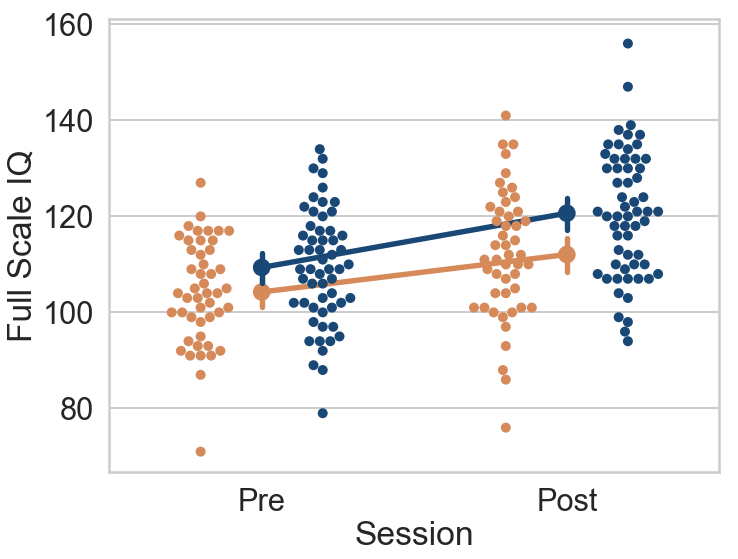

In [28]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.swarmplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long, palette=crayons_d, dodge=True, ax=ax, size=mksz)
k.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long, ax=ax, palette=crayons_d)
j.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ.png', dpi=300)

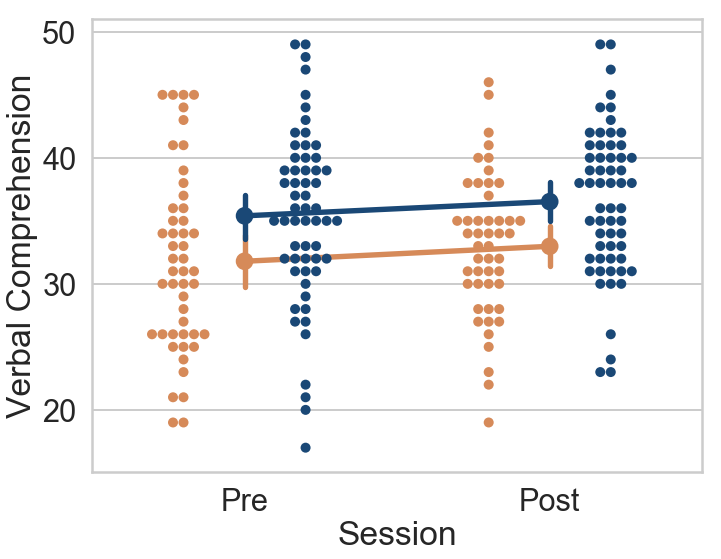

In [29]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-vcIQ.png', dpi=300)

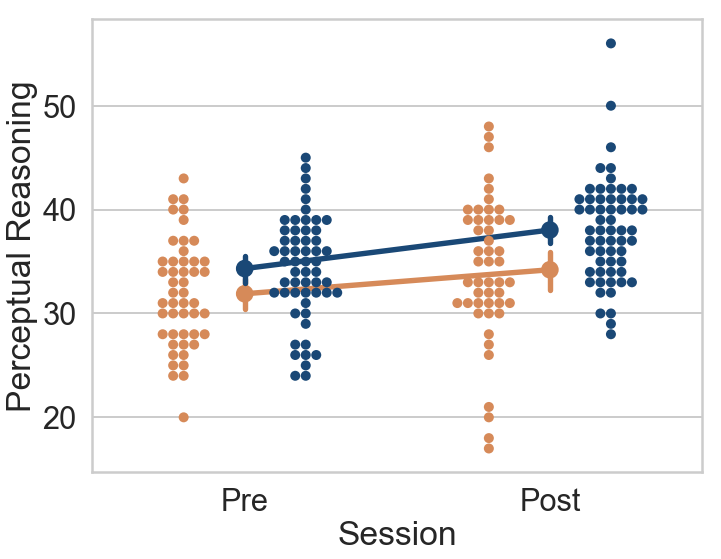

In [30]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-prIQ.png', dpi=300)

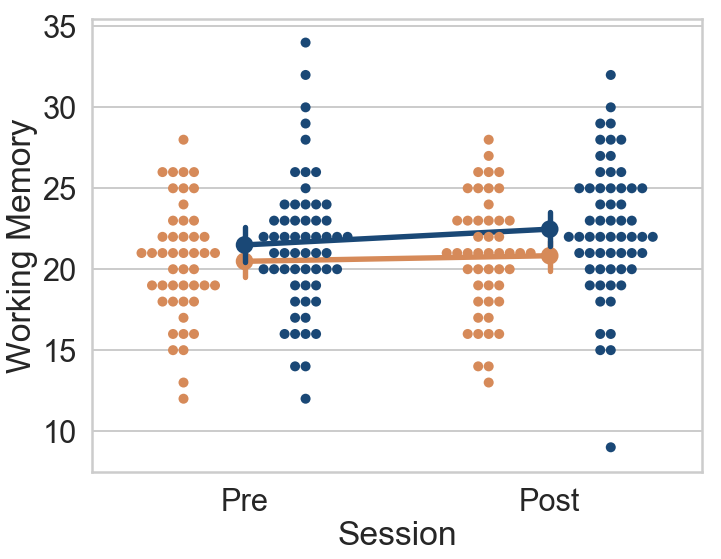

In [31]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=1.5)
mksz = 10
k = sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-wmIQ.png', dpi=300)

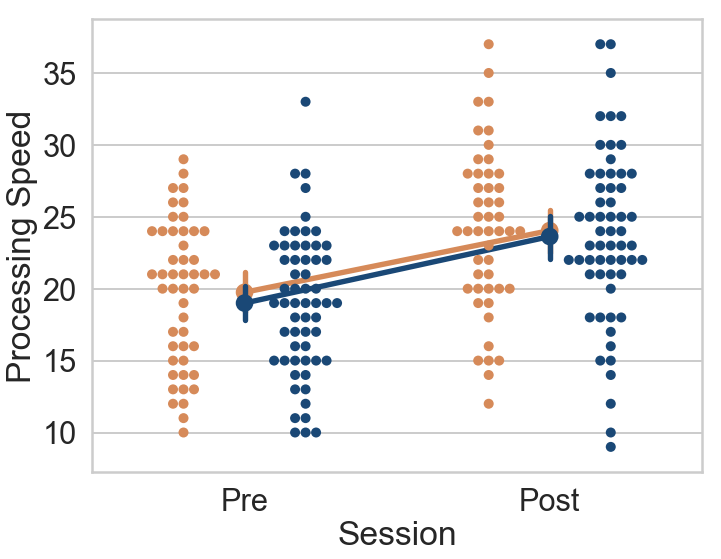

In [32]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
mksz = 10
plt.tight_layout(pad=1.5)
k = sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-psIQ.png', dpi=300)

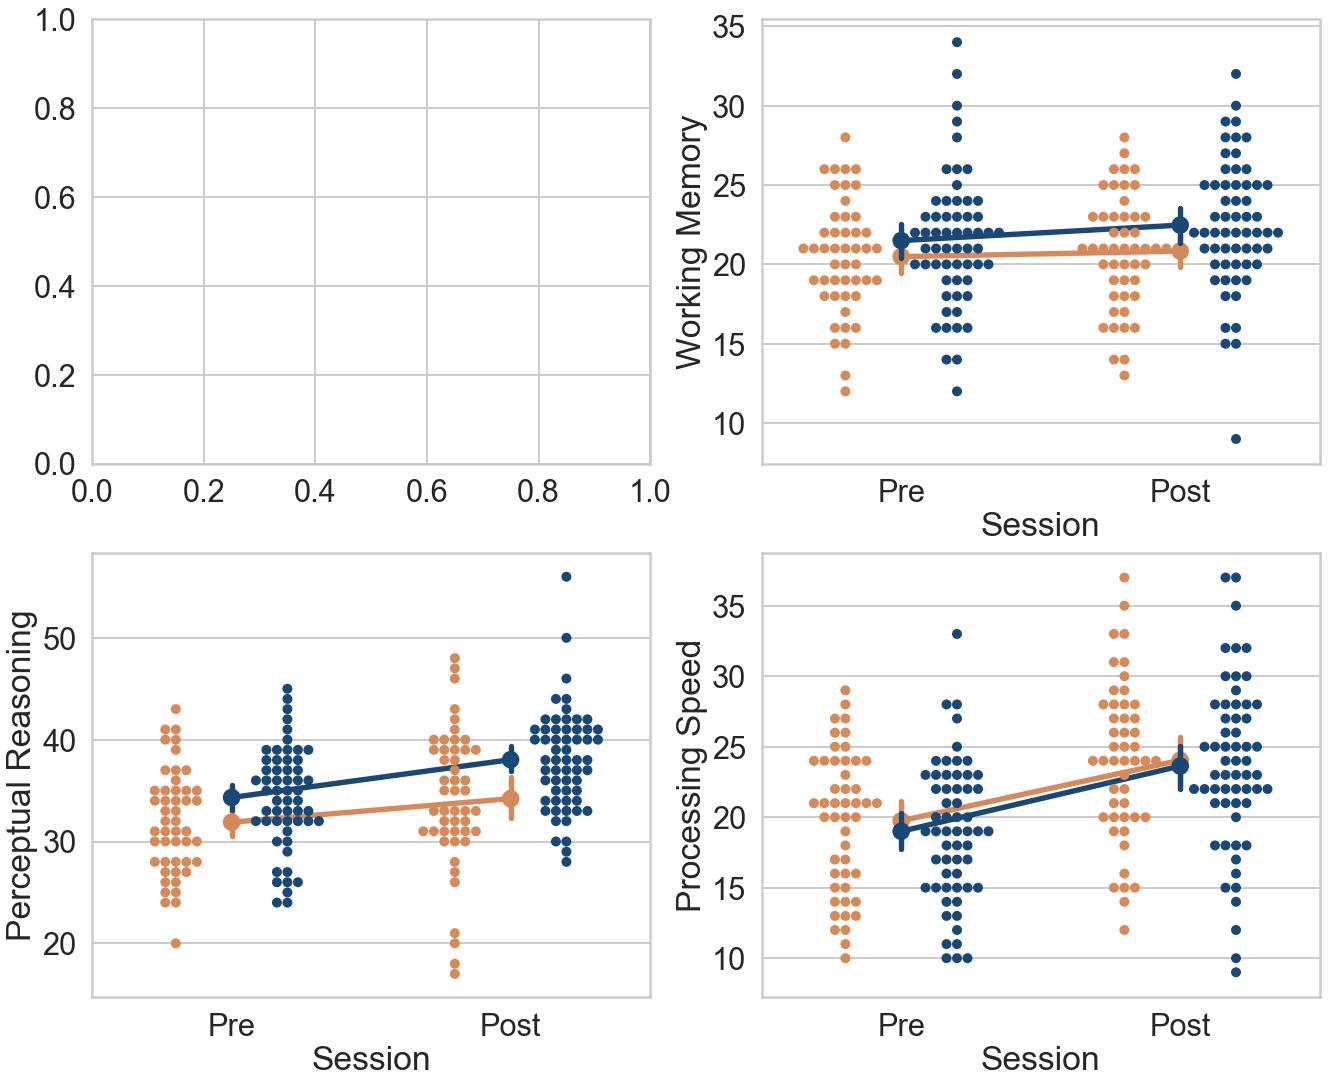

In [33]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(22, 18), sharex=False, sharey=False, squeeze=True)
mksz = 10


sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax[1][0], size=mksz)
sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax[0][1], size=mksz)
sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax[1][1], size=mksz)


h = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax[1][0], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax[0][1], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
j.get_legend().set_visible(False)


fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ-subscores.png', dpi=300)

## Does IQ facilitate learning?
Is pre-instruction IQ significantly related to academic performance or change in physics knowledge/reasoning?

In [34]:
for i in iqs:
    print('does pre {0} IQ correlate with post grade?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_1'.format(i)], df_dudes['Phy48Grade'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_1'.format(i)], df_ladies['Phy48Grade'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes pre {0} IQ correlate with delta physics retrieval accuracy?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_1'.format(i)], 
                            df_dudes['Mean Physics Retrieval Accuracy Post'] - df_dudes['Mean Physics Retrieval Accuracy Pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_1'.format(i)], 
                            df_ladies['Mean Physics Retrieval Accuracy Post'] - df_ladies['Mean Physics Retrieval Accuracy Pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes pre {0} IQ correlate with delta FCI accuracy?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_1'.format(i)], 
                            df_dudes['Post Mean FCI Accuracy'] - df_dudes['Pre Mean FCI Accuracy'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_1'.format(i)], 
                            df_ladies['Post Mean FCI Accuracy'] - df_ladies['Pre Mean FCI Accuracy'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does pre Verbal Comprehension  IQ correlate with post grade?
male students
r = -0.0438080001, p = 0.7440265296
female students
r = 0.0209325899, p = 0.8876978849

does pre Verbal Comprehension  IQ correlate with delta physics retrieval accuracy?
male students
r = -0.063424929, p = 0.6362191599
female students
r = -0.223032796, p = 0.1275709935

does pre Verbal Comprehension  IQ correlate with delta FCI accuracy?
male students
r = 0.1016111126, p = 0.4478710823
female students
r = 0.062703098, p = 0.6720138911

does pre Perceptual Reasoning  IQ correlate with post grade?
male students
r = -0.0133744475, p = 0.9220655637
female students
r = -0.1199483833, p = 0.41675771

does pre Perceptual Reasoning  IQ correlate with delta physics retrieval accuracy?
male students
r = -0.1883710785, p = 0.1644290766
female students
r = -0.179952586, p = 0.2209880164

does pre Perceptual Reasoning  IQ correlate with delta FCI accuracy?
male students
r = -0.2172525192, p = 0.1077528193
female students
r 

## Does IQ reflect learning?
Is the change in IQ over the duration of the course related to academic performance or change in physics knowledge/reasoning?

In [35]:
for iq in ['Full Scale IQ', 'Perceptual Reasoning Sum', 'Processing Speed Sum']:
    print('does the change in {0} IQ correlate with post grade?'.format(iq[:-3]))
    dude_diq_grade = spearmanr(df_dudes['{0}_2'.format(iq)] - df_dudes['{0}_1'.format(iq)], 
                              df_dudes['Phy48Grade'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_diq_grade.correlation, 10), 
                                                   np.round(dude_diq_grade.pvalue, 10)))

    lady_diq_grade = spearmanr(df_ladies['{0}_2'.format(iq)] - df_ladies['{0}_1'.format(iq)], 
                              df_ladies['Phy48Grade'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_diq_grade.correlation, 10), 
                                                   np.round(lady_diq_grade.pvalue, 10)))

    print('\ndoes the change in {0} IQ correlate with physics retrieval accuracy?'.format(iq[:-3]))
    dude_diq_acc = spearmanr(df_dudes['{0}_2'.format(iq)] - df_dudes['{0}_1'.format(iq)], 
                            df_dudes['Mean Physics Retrieval Accuracy Post'] - df_dudes['Mean Physics Retrieval Accuracy Pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_diq_acc.correlation, 10), 
                                                   np.round(dude_diq_acc.pvalue, 10)))

    lady_diq_acc = spearmanr(df_ladies['{0}_2'.format(iq)] - df_ladies['{0}_1'.format(iq)], 
                            df_ladies['Mean Physics Retrieval Accuracy Post'] - df_ladies['Mean Physics Retrieval Accuracy Pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_diq_acc.correlation, 10),
                                                     np.round(lady_diq_acc.pvalue, 10)))

    print('\ndoes the change in {0} IQ correlate with delta FCI accuracy?'.format(iq[:-3]))
    dude_diq_fci = spearmanr(df_dudes['{0}_2'.format(iq)] - df_dudes['{0}_1'.format(iq)], 
                            df_dudes['Post Mean FCI Accuracy'] - df_dudes['Pre Mean FCI Accuracy'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_diq_fci.correlation, 10), 
                                                   np.round(dude_diq_fci.pvalue, 10)))

    lady_diq_fci = spearmanr(df_ladies['{0}_2'.format(iq)] - df_ladies['{0}_1'.format(iq)], 
                            df_ladies['Post Mean FCI Accuracy'] - df_ladies['Pre Mean FCI Accuracy'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_diq_fci.correlation, 10),
                                                     np.round(lady_diq_fci.pvalue, 10)))

does the change in Full Scale IQ correlate with post grade?
male students
r = -0.0003850706, p = 0.9977526731
female students
r = -0.1036699464, p = 0.4880214077

does the change in Full Scale IQ correlate with physics retrieval accuracy?
male students
r = 0.1041303911, p = 0.4450192523
female students
r = 0.0525370777, p = 0.7257986174

does the change in Full Scale IQ correlate with delta FCI accuracy?
male students
r = 0.0201384525, p = 0.8828808215
female students
r = 0.10061599, p = 0.5009950694

does the change in Perceptual Reasoning  IQ correlate with post grade?
male students
r = 0.0748336774, p = 0.5835937334
female students
r = 0.4192812173, p = 0.0030140049

does the change in Perceptual Reasoning  IQ correlate with physics retrieval accuracy?
male students
r = 0.0574303504, p = 0.6741760973
female students
r = 0.0636227104, p = 0.6674810676

does the change in Perceptual Reasoning  IQ correlate with delta FCI accuracy?
male students
r = 0.0881720177, p = 0.5181514304
femal

In [36]:
jili_sidak_mc(rsgt_df, 0.05)

Number of effective comparisons: 2.270881622002304
Critical value of 0.050 becomes 0.022334 after corrections


(0.022334207142188034, 2.270881622002304)

## Is IQ related to global brain organization?
pre-instruction IQ and efficiency, characteristic path length, and modularity. same for post. how does this relationship change?

In [37]:
for i in iqs:
    print('does pre {0} IQ correlate with pre efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_1'.format(i)], df_dudes['eff pre'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_1'.format(i)], df_ladies['eff pre'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes pre {0} IQ correlate with pre modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_1'.format(i)], 
                            df_dudes['mod pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_1'.format(i)], 
                            df_ladies['mod pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes pre {0} IQ correlate with pre charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_1'.format(i)], 
                            df_dudes['cpl pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_1'.format(i)], 
                            df_ladies['cpl pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does pre Verbal Comprehension  IQ correlate with pre efficiency?
male students
r = 0.0125449113, p = 0.9255356926
female students
r = 0.2181249724, p = 0.1363877204

does pre Verbal Comprehension  IQ correlate with pre modularity?
male students
r = 0.0436760179, p = 0.7447715243
female students
r = -0.2087689885, p = 0.1544426358

does pre Verbal Comprehension  IQ correlate with pre charpath?
male students
r = 0.036586756, p = 0.7851129391
female students
r = 0.2196480395, p = 0.1336042726

does pre Perceptual Reasoning  IQ correlate with pre efficiency?
male students
r = -0.0998838919, p = 0.4639008588
female students
r = 0.2418974034, p = 0.0976327705

does pre Perceptual Reasoning  IQ correlate with pre modularity?
male students
r = 0.0238569625, p = 0.86145106
female students
r = -0.0973250579, p = 0.5104875195

does pre Perceptual Reasoning  IQ correlate with pre charpath?
male students
r = -0.0294784307, p = 0.8292467207
female students
r = 0.2561042491, p = 0.0789169585

does pr

In [38]:
for i in iqs:
    print('does post {0} IQ correlate with post efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_2'.format(i)], df_dudes['eff post'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_2'.format(i)], df_ladies['eff post'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes post {0} IQ correlate with post modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_2'.format(i)], 
                            df_dudes['mod post'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_2'.format(i)], 
                            df_ladies['mod post'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes post {0} IQ correlate with post charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_2'.format(i)], 
                            df_dudes['cpl post'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_2'.format(i)], 
                            df_ladies['cpl post'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does post Verbal Comprehension  IQ correlate with post efficiency?
male students
r = -0.1635229429, p = 0.2200031741
female students
r = -0.0259204172, p = 0.8611759037

does post Verbal Comprehension  IQ correlate with post modularity?
male students
r = 0.153659165, p = 0.249479879
female students
r = 0.0066434683, p = 0.9642551743

does post Verbal Comprehension  IQ correlate with post charpath?
male students
r = -0.2111464955, p = 0.1116018634
female students
r = -0.0381182605, p = 0.7970065279

does post Perceptual Reasoning  IQ correlate with post efficiency?
male students
r = -0.060918725, p = 0.6496373612
female students
r = -0.1135366046, p = 0.4422736635

does post Perceptual Reasoning  IQ correlate with post modularity?
male students
r = 0.0963774965, p = 0.4717164768
female students
r = -0.0102868736, p = 0.944677048

does post Perceptual Reasoning  IQ correlate with post charpath?
male students
r = -0.0533578903, p = 0.6907782108
female students
r = -0.1101076468, p = 0.456

In [43]:
for i in iqs:
    print('does pre {0} IQ correlate with change in efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_1'.format(i)], 
                              df_dudes['eff post'] - df_dudes['eff pre'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_1'.format(i)], 
                              df_ladies['eff post'] - df_ladies['eff pre'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes pre {0} IQ correlate with change in modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_1'.format(i)], 
                            df_dudes['mod post'] - df_dudes['mod pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_1'.format(i)], 
                            df_ladies['mod post'] - df_ladies['mod pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes pre {0} IQ correlate with change in charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_1'.format(i)], 
                            df_dudes['cpl post'] - df_dudes['cpl pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_1'.format(i)], 
                            df_ladies['cpl post'] - df_ladies['cpl pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does pre Verbal Comprehension  IQ correlate with change in efficiency?
male students
r = -0.0839409975, p = 0.5347328656
female students
r = 0.0490101247, p = 0.7407951899

does pre Verbal Comprehension  IQ correlate with change in modularity?
male students
r = 0.1071262479, p = 0.427688453
female students
r = -0.0725088749, p = 0.6243039051

does pre Verbal Comprehension  IQ correlate with change in charpath?
male students
r = -0.0671852703, p = 0.6194981683
female students
r = 0.0255657698, p = 0.8630570456

does pre Perceptual Reasoning  IQ correlate with change in efficiency?
male students
r = 0.1557147296, p = 0.2562798972
female students
r = -0.129331285, p = 0.3809746619

does pre Perceptual Reasoning  IQ correlate with change in modularity?
male students
r = -0.0203373642, p = 0.8828346094
female students
r = -0.0356531951, p = 0.8098823356

does pre Perceptual Reasoning  IQ correlate with change in charpath?
male students
r = 0.0419774777, p = 0.7609016685
female students
r = 

In [44]:
for i in iqs:
    print('does post {0} IQ correlate with change in efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_2'.format(i)], 
                              df_dudes['eff post'] - df_dudes['eff pre'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_2'.format(i)], 
                              df_ladies['eff post'] - df_ladies['eff pre'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes post {0} IQ correlate with change in modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_2'.format(i)], 
                            df_dudes['mod post'] - df_dudes['mod pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_2'.format(i)], 
                            df_ladies['mod post'] - df_ladies['mod pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes post {0} IQ correlate with change in charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_2'.format(i)], 
                            df_dudes['cpl post'] - df_dudes['cpl pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_2'.format(i)], 
                            df_ladies['cpl post'] - df_ladies['cpl pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does post Verbal Comprehension  IQ correlate with change in efficiency?
male students
r = -0.0480242686, p = 0.7203531474
female students
r = 0.0085493813, p = 0.954010275

does post Verbal Comprehension  IQ correlate with change in modularity?
male students
r = 0.09814459, p = 0.4635900193
female students
r = -0.0318559749, p = 0.8298129828

does post Verbal Comprehension  IQ correlate with change in charpath?
male students
r = -0.0684299591, p = 0.6097703597
female students
r = -0.0470488244, p = 0.7508282674

does post Perceptual Reasoning  IQ correlate with change in efficiency?
male students
r = 0.1126410061, p = 0.3998674624
female students
r = -0.2414966034, p = 0.0982065853

does post Perceptual Reasoning  IQ correlate with change in modularity?
male students
r = -0.097303313, p = 0.4674493629
female students
r = 0.0771243378, p = 0.6023491072

does post Perceptual Reasoning  IQ correlate with change in charpath?
male students
r = 0.0577709489, p = 0.6666480462
female students


In [45]:
for i in iqs:
    print('does change in {0} IQ correlate with post efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                              df_dudes['eff post'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                              df_ladies['eff post'] , nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes change in {0} IQ correlate with post modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                            df_dudes['mod post'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                            df_ladies['mod post'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes change in {0} IQ correlate with post charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                            df_dudes['cpl post'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                            df_ladies['cpl post'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does change in Verbal Comprehension  IQ correlate with post efficiency?
male students
r = 0.0891431046, p = 0.5096261007
female students
r = -0.2916551668, p = 0.0442889069

does change in Verbal Comprehension  IQ correlate with post modularity?
male students
r = -0.1465771515, p = 0.2765926527
female students
r = 0.4605024229, p = 0.0009893836

does change in Verbal Comprehension  IQ correlate with post charpath?
male students
r = 0.0521004209, p = 0.7003139939
female students
r = -0.3052217905, p = 0.0348993078

does change in Perceptual Reasoning  IQ correlate with post efficiency?
male students
r = 0.0126969672, p = 0.9266948081
female students
r = -0.2470265727, p = 0.0905160797

does change in Perceptual Reasoning  IQ correlate with post modularity?
male students
r = 0.0157355576, p = 0.9092182913
female students
r = 0.1207358712, p = 0.4136828832

does change in Perceptual Reasoning  IQ correlate with post charpath?
male students
r = 0.050389958, p = 0.714849659
female students


In [46]:
for i in iqs:
    print('does change in {0} IQ correlate with pre efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                              df_dudes['eff pre'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                              df_ladies['eff pre'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes change in {0} IQ correlate with pre modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                            df_dudes['mod pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                            df_ladies['mod pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes change in {0} IQ correlate with pre charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                            df_dudes['cpl pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                            df_ladies['cpl pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does change in Verbal Comprehension  IQ correlate with pre efficiency?
male students
r = 0.0488876516, p = 0.7155366256
female students
r = -0.2649033105, p = 0.0688222519

does change in Verbal Comprehension  IQ correlate with pre modularity?
male students
r = -0.122219129, p = 0.3607359225
female students
r = 0.2281263186, p = 0.1188812427

does change in Verbal Comprehension  IQ correlate with pre charpath?
male students
r = -0.0110182397, p = 0.9345765787
female students
r = -0.2665378435, p = 0.0670653807

does change in Perceptual Reasoning  IQ correlate with pre efficiency?
male students
r = 0.0583288431, p = 0.6693704793
female students
r = 0.0273384787, p = 0.8536618438

does change in Perceptual Reasoning  IQ correlate with pre modularity?
male students
r = 0.0386231529, p = 0.7774713799
female students
r = -0.1307018903, p = 0.3759050085

does change in Perceptual Reasoning  IQ correlate with pre charpath?
male students
r = 0.0167926752, p = 0.9022344438
female students
r = 

In [39]:
for i in iqs:
    print('does change in {0} IQ correlate with change in efficiency?'.format(i[:-3]))
    dude_iq_grade = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                              df_dudes['eff post'] - df_dudes['eff pre'], nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_grade.correlation, 10), 
                                                   np.round(dude_iq_grade.pvalue, 10)))

    lady_iq_grade = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                              df_ladies['eff post'] - df_ladies['eff pre'], nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_grade.correlation, 10), 
                                                   np.round(lady_iq_grade.pvalue, 10)))

    print('\ndoes change in {0} IQ correlate with change in modularity?'.format(i[:-3]))
    dude_iq_acc = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                            df_dudes['mod post'] - df_dudes['mod pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_acc.correlation, 10), 
                                                   np.round(dude_iq_acc.pvalue, 10)))

    lady_iq_acc = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                            df_ladies['mod post'] - df_ladies['mod pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}'.format(np.round(lady_iq_acc.correlation, 10),
                                                     np.round(lady_iq_acc.pvalue, 10)))

    print('\ndoes change in {0} IQ correlate with change in charpath?'.format(i[:-3]))
    dude_iq_fci = spearmanr(df_dudes['{0}_2'.format(i)] - df_dudes['{0}_1'.format(i)], 
                            df_dudes['cpl post'] - df_dudes['cpl pre'], 
                            nan_policy='omit')
    print('male students\nr = {0}, p = {1}'.format(np.round(dude_iq_fci.correlation, 10), 
                                                   np.round(dude_iq_fci.pvalue, 10)))

    lady_iq_fci = spearmanr(df_ladies['{0}_2'.format(i)] - df_ladies['{0}_1'.format(i)], 
                            df_ladies['cpl post'] - df_ladies['cpl pre'], 
                            nan_policy='omit')
    print('female students\nr = {0}, p = {1}\n'.format(np.round(lady_iq_fci.correlation, 10),
                                                     np.round(lady_iq_fci.pvalue, 10)))

does change in Verbal Comprehension  IQ correlate with change in efficiency?
male students
r = -0.0416933455, p = 0.7581295043
female students
r = -0.0113327619, p = 0.9390623447

does post Verbal Comprehension  IQ correlate with post modularity?
male students
r = 0.0061141568, p = 0.9639968397
female students
r = 0.0606956577, p = 0.6819486486

does post Verbal Comprehension  IQ correlate with post charpath?
male students
r = -0.0231882647, p = 0.8640570974
female students
r = -0.0338348325, p = 0.8194124087

does change in Perceptual Reasoning  IQ correlate with change in efficiency?
male students
r = -0.0219212596, p = 0.8737812764
female students
r = -0.2866728127, p = 0.0482168161

does post Perceptual Reasoning  IQ correlate with post modularity?
male students
r = -0.0706834013, p = 0.6080884496
female students
r = 0.251655598, p = 0.0844458994

does post Perceptual Reasoning  IQ correlate with post charpath?
male students
r = 0.0682597637, p = 0.6204739849
female students
r = -0